# CHE 1148 Assignment 4
Name: Fendi Halim Tjoa

Student ID: 100753017

Instructor: Nikolaos Anesiadis

TA: Kavya Siddartha

Note: This notebook runs on google colab


In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.cross_decomposition import PLSRegression
from pandas.tseries.offsets import DateOffset
from itertools import product
from pandas.tseries.offsets import MonthEnd 
from sklearn.model_selection import train_test_split
from matplotlib.ticker import PercentFormatter
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
Retail_Data_Response = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Retail_Data_Response.csv') #import Retail_Data_Transactions.csv as pd dataframe
# annual_features = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/annual_features.xlsx') #import Retail_Data_Transactions.csv as pd dataframe
# annual_day_of_week_counts_pivot = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/annual_day_of_week_counts_pivot.xlsx') #import Retail_Data_Transactions.csv as pd dataframe
mth_rolling_features = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/mth_rolling_features.xlsx', index_col = 0) #import Retail_Data_Transactions.csv as pd dataframe
mth_day_counts = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/mth_day_counts.xlsx', index_col = 0) #import Retail_Data_Transactions.csv as pd dataframe
days_since_last_txn = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/days_since_last_txn.xlsx', index_col = 0) #import Retail_Data_Transactions.csv as pd dataframe


In [4]:
monthly_features_output = mth_rolling_features.merge(mth_day_counts, left_on=  ['CLNT_NO', 'ME_DT'], right_on= ['CLNT_NO', 'ME_DT']).merge(
    days_since_last_txn, left_on=  ['CLNT_NO', 'ME_DT'], right_on= ['CLNT_NO', 'ME_DT'])

monthly_features_output = pd.merge(monthly_features_output, Retail_Data_Response.set_index('customer_id'), left_on='CLNT_NO', right_index=True)
monthly_features_output.fillna(0, inplace = True) # change nan to 0
monthly_features_output['response'] = monthly_features_output['response'].astype(int) # change response to integer


In [6]:
monthly_features_output.shape

(323548, 31)

In [8]:
X_monthly = monthly_features_output.drop(['response'], axis = 1)
y_monthly = monthly_features_output['response']
# X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_monthly, y_monthly, test_size=2/3, random_state=1147)

Data prior to Dec-2013 inclusively

In [9]:
cust_and_date_pre_dec = monthly_features_output[monthly_features_output['ME_DT'] <= '2013-12-31'][['CLNT_NO','ME_DT']]
X_pre_dec = monthly_features_output[monthly_features_output['ME_DT'] <= '2013-12-31'].drop(['response','CLNT_NO','ME_DT'], axis = 1)
y_pre_dec = monthly_features_output[monthly_features_output['ME_DT'] <= '2013-12-31']['response']

Train model

In [10]:
randomtree_ann = RandomForestClassifier(random_state=0, max_depth = 1, n_estimators=36, max_features = 14)
randomtree_ann.fit(X_pre_dec, y_pre_dec) # fit non scaled data

RandomForestClassifier(max_depth=1, max_features=14, n_estimators=36,
                       random_state=0)

Capturing feature importances

In [11]:
importances_pre_dec = randomtree_ann.feature_importances_
importances_pre_dec

array([0.        , 0.        , 0.        , 0.        , 0.05555556,
       0.        , 0.        , 0.        , 0.13888889, 0.05555556,
       0.41666667, 0.        , 0.        , 0.        , 0.25      ,
       0.08333333, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [12]:
# Feature importances
X_pre_dec.iloc[:, np.argsort(-importances_pre_dec)[:5]].columns.values

array(['amt_max_6M', 'amt_sum_12M', 'amt_sum_6M', 'amt_mean_12M',
       'amt_max_3M'], dtype=object)

### Training Score (Baseline Score)

In [13]:
baseline_scores = randomtree_ann.predict_proba(X_pre_dec)[:,1]

In [14]:
baseline_scores.max()

0.11947352444117532

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Baseline Score')]

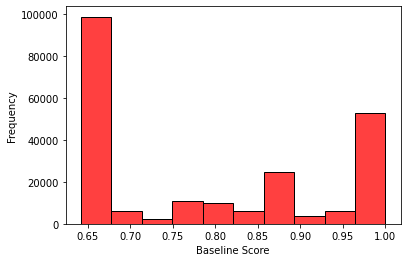

In [15]:
baseline_scores = baseline_scores/baseline_scores.max()
ax = sns.histplot(baseline_scores,                
                  color='red',
                  bins=10)
ax.set(xlabel='Baseline Score', ylabel='Frequency')

### Baseline P-vector

In [16]:
p_histz, bin_edge = pd.qcut(baseline_scores, 11, labels = False, retbins=True, duplicates = 'drop')
p = pd.Series(p_histz).value_counts().to_numpy()
bin_edge[0] = 0
p, bin_edge

(array([100577,  35203,  24089,  20974,  20104,  19341]),
 array([0.        , 0.70078222, 0.79458372, 0.86097615, 0.91349878,
        0.97989121, 1.        ]))

Check binning

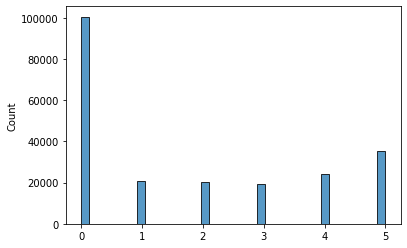

In [17]:
sns.histplot(p_histz)

### 5 Features Drift

In [18]:
five_feature = X_pre_dec[X_pre_dec.iloc[:, np.argsort(-importances_pre_dec)[:5]].columns.values]
feature_baseline_scores = []
for i in range(5):
  temp = five_feature.iloc[:,i]
  feature_baseline_scores.append(temp)


In [19]:
five_feature.columns

Index(['amt_max_6M', 'amt_sum_12M', 'amt_sum_6M', 'amt_mean_12M',
       'amt_max_3M'],
      dtype='object')

Count distribution before proper binning

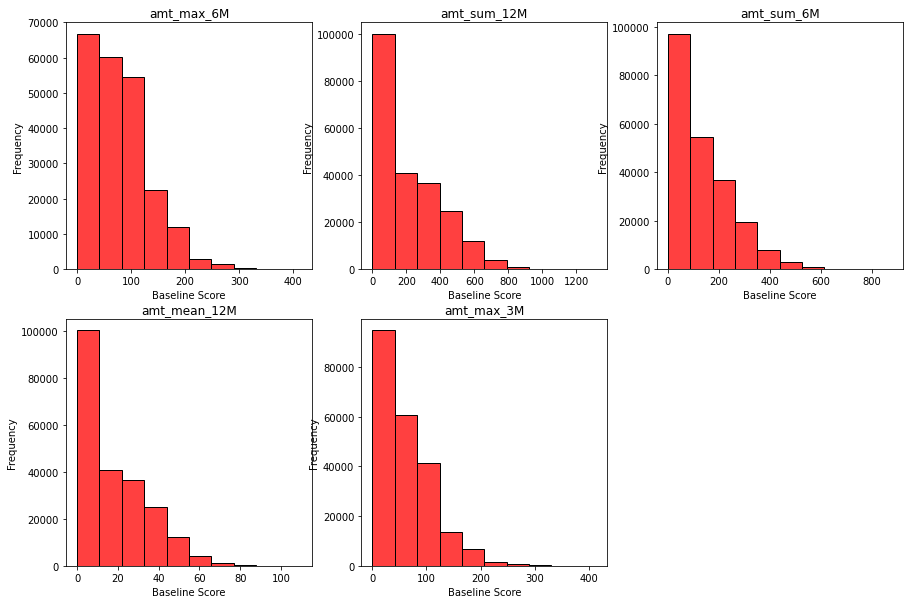

In [20]:
plt.figure(figsize=(15, 10))
for i in range(5):
  plt.subplot(2,3,i+1)
  sns.histplot(feature_baseline_scores[i],                
                  color='red',
                  bins=10)
  plt.title(X_pre_dec.iloc[:, np.argsort(-importances_pre_dec)[:5]].columns.values[i])
  plt.xlabel('Baseline Score')
  plt.ylabel('Frequency')

plt.show()

In [21]:
p_feature = []
bin_edge_feature = []
for i in range(5):
  feat_p_temp, bin_temp = pd.qcut(five_feature.iloc[:,i], 11, labels = False, retbins=True, duplicates = 'drop')
  bin_temp[0] = 0
  bin_temp[-1] = np.inf
  p_feature.append(feat_p_temp)
  bin_edge_feature.append(bin_temp)

Duplicates (multiple bin-0s) are removed

Check binning

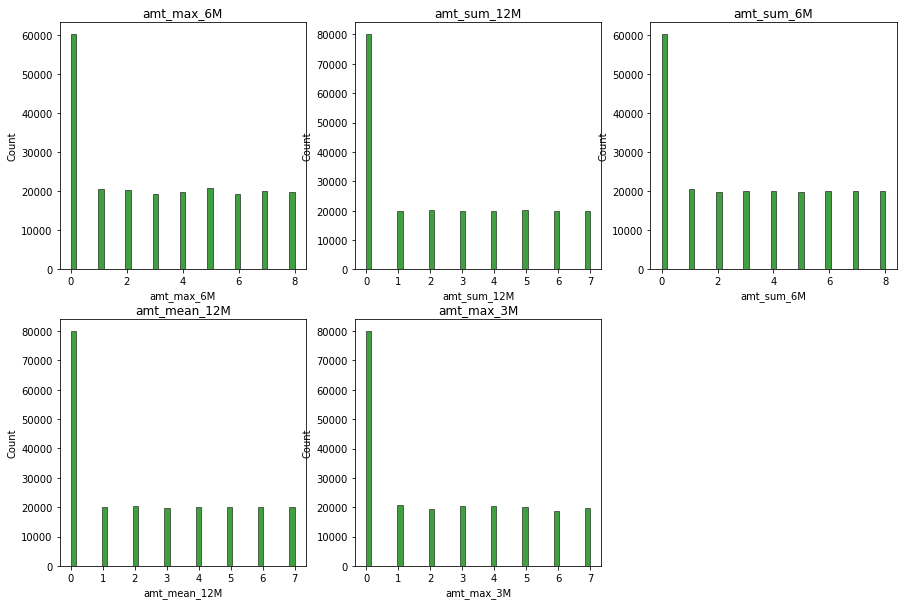

In [22]:
plt.figure(figsize=(15, 10))
for i in range(5):
  plt.subplot(2,3,i+1)
  sns.histplot(p_feature[i],                
                  color='green')
  plt.title(X_pre_dec.iloc[:, np.argsort(-importances_pre_dec)[:5]].columns.values[i])

plt.show()

# Monthly Score

In [23]:
# starting 2014 

cust_and_date_starting_2014 = monthly_features_output[pd.DatetimeIndex(monthly_features_output['ME_DT']).year >= 2014][['CLNT_NO','ME_DT']]

X_starting_2014 = monthly_features_output[pd.DatetimeIndex(monthly_features_output['ME_DT']).year >= 2014] #.drop(['response','CLNT_NO','ME_DT'], axis = 1)

year_we_have = X_starting_2014['ME_DT'].dt.year.unique()
month_we_have = X_starting_2014['ME_DT'].dt.month.unique()


Capture date and Score for every month

In [66]:
valz = []
date_date = []
for i in year_we_have:
  for j in month_we_have:
    if i == 2015 and j == 4:
      break
    else:
      # print(j)
      temp = randomtree_ann.predict_proba(X_starting_2014[(pd.DatetimeIndex(X_starting_2014['ME_DT']).year == i) & (pd.DatetimeIndex(X_starting_2014['ME_DT']).month == j)].drop(['response','CLNT_NO','ME_DT'], axis = 1))
      temp = temp[:,1]/temp[:,1].max()
      date_date.append(X_starting_2014[(pd.DatetimeIndex(X_starting_2014['ME_DT']).year == i) & (pd.DatetimeIndex(X_starting_2014['ME_DT']).month == j)]['ME_DT'].dt.date.unique()[0])
      valz.append(temp)

Convert to q vector

In [26]:
q_list = []
for i in range(len(valz)):
  tempa, tempb = np.histogram(valz[i], bin_edge)
  q_list.append(tempa)


Calculate Jensen-Shannon divergence value

In [27]:
score_jensenshannon = []
for i in range(len(q_list)):
  score_jensenshannon.append(distance.jensenshannon(p, q_list[i], 2.0))


# Features

In [28]:
five_feature.columns

Index(['amt_max_6M', 'amt_sum_12M', 'amt_sum_6M', 'amt_mean_12M',
       'amt_max_3M'],
      dtype='object')

In [29]:
p_feature_array = []
for i in range(5):
  p_feature_array.append(p_feature[i].value_counts().to_numpy())


In [30]:
feature_bank = []

for i in year_we_have:
  for j in month_we_have:
    if i == 2015 and j == 4:
      break
    else:
      temp = X_starting_2014[(pd.DatetimeIndex(X_starting_2014['ME_DT']).year == i) & (pd.DatetimeIndex(X_starting_2014['ME_DT']).month == j)][five_feature.columns]
      feature_bank.append(temp)


Capturing Jensen-Shannon Divergence Value for each feature per month

In [31]:
# len(feature_bank)
q_feature = []
feat_1 = []
feat_2 = []
feat_3 = []
feat_4 = []
feat_5 = []

for i in range(len(feature_bank)): # months
  for j in range(5): # 5 feature
    if j == 0:
      temp,_ = np.histogram(feature_bank[i].iloc[:,j].to_numpy(), bin_edge_feature[j])
      rez = distance.jensenshannon(p_feature_array[j], temp, 2.0)
      feat_1.append(rez)
    elif j == 1:
      temp,_ = np.histogram(feature_bank[i].iloc[:,j].to_numpy(), bin_edge_feature[j])
      rez = distance.jensenshannon(p_feature_array[j], temp, 2.0)
      feat_2.append(rez)
    elif j == 2:
      temp,_ = np.histogram(feature_bank[i].iloc[:,j].to_numpy(), bin_edge_feature[j])
      rez = distance.jensenshannon(p_feature_array[j], temp, 2.0)
      feat_3.append(rez)
    elif j == 3:
      temp,_ = np.histogram(feature_bank[i].iloc[:,j].to_numpy(), bin_edge_feature[j])
      rez = distance.jensenshannon(p_feature_array[j], temp, 2.0)
      feat_4.append(rez)
    elif j == 4:
      temp,_ = np.histogram(feature_bank[i].iloc[:,j].to_numpy(), bin_edge_feature[j])
      rez = distance.jensenshannon(p_feature_array[j], temp, 2.0)
      feat_5.append(rez)


## Dashboard

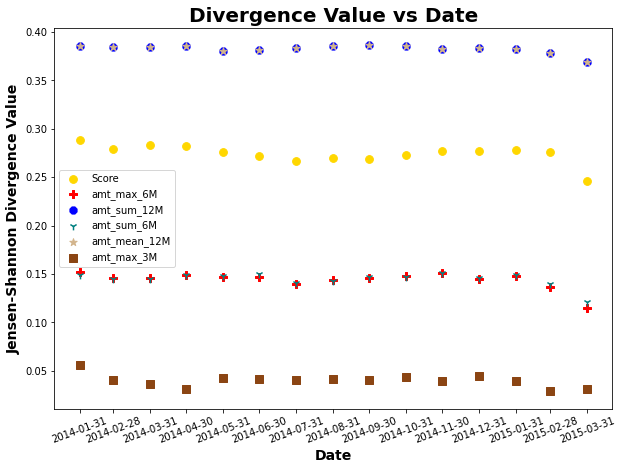

In [70]:
plt.figure(figsize=(10, 7))
plt.scatter(date_date, score_jensenshannon, marker='o', s=60, color = 'gold', label= 'Score')
plt.scatter(date_date, feat_1, marker='P',s=60, color = 'red', label= five_feature.columns[0])
plt.scatter(date_date, feat_2, marker='8',s=60, color = 'blue', label= five_feature.columns[1])
plt.scatter(date_date, feat_3, marker='1',s=60, color = 'Teal', label= five_feature.columns[2])
plt.scatter(date_date, feat_4, marker='*',s=60, color = 'Tan', label= five_feature.columns[3])
plt.scatter(date_date, feat_5, marker='s',s=60, color = 'SaddleBrown', label= five_feature.columns[4])
plt.title('Divergence Value vs Date', fontsize = 20, fontdict=dict(weight='bold'))
plt.ylabel('Jensen-Shannon Divergence Value', fontsize = 14, fontdict=dict(weight='bold'))
plt.xlabel('Date', fontsize = 14, fontdict=dict(weight='bold'))
# plt.xticks(np.arange(0, 51, 5)) 
plt.xticks(date_date, date_date, rotation ='20')
# plt.xticks(date_date)
# plt.xticks(np.arange(1,16,1))
plt.legend()
plt.show()

### Intepretation and Comments

- The Jensen-Shannon Divergence Values of scores and 5 features are all below 2. That means, there are not much difference in the distribution. It means there is no drift among the data per each month. 
- The Jensen-Shannon Divergence value of amt_sum_12m and amt_mean_12m follow closely to each other. It is very obvious that they're the same because they are aggregate values coming from the same data.
- In addition to that, the Jensen-Shannon Divergence value of amt_max_6m and amt_sum_6m also follow closely to each other with the same reason.
- An interesting observation is that the the Jensen-Shannon Divergence value of scores have the same pattern with amt_max_6m and amt_sum_6m. 
- During March 2015, the divergence value of scores and the four features above dropped together.